# Cheat Sheet for `ssgbm`

This notebook provides some examples of how to use `ScoreBasedGenerator` of `ssgbm` package.

## Index

1. [Preparation](#Preparation)
2. [Basic Usage](#Basic-Usage)
   1. [Generate samples of $x$ with observed $\{x_n\}_{n=1}^N$](#generate_samples_with_x)
   2. [Generate samples of $y$ conditioned by $x$ with observed $\{(x_n, y_n)\}_{n=1}^N$](#generate_samples_with_x_and_y)
3. [Advanced Usage](#Advanced-Usage)
   1. [Generate samples of $x$ with observed $\{x_n\}_{n=1}^N$ with $x$ restricted](#generate_samples_with_restricted_x)
   2. [Generate samples of $y$ conditioned by $x$ with observed $\{(x_n, y_n)\}_{n=1}^N$ with $y$ restricted partially](#generate_samples_with_partially_restricted)

## Preparation

In [1]:
%pip install sympy

Note: you may need to restart the kernel to use updated packages.


d:\dev_libs\ssbgm\.venv\Scripts\python.exe: No module named pip


In [2]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
import sympy

import sys
sys.path.append('../')
from ssbgm import ScoreBasedGenerator

In [3]:
np.random.seed(42)

In [4]:
# parameters
Ntr = 10000

## Basic Usage

### Generate samples of $x$ with observed $\{x_n\}_{n=1}^N$

<span id="generate_samples_with_x"></span>

In this section, we will generate samples of $x$ with observed $\{x_n\}_{n=1}^N$.

Asssume $\{x_n\}_{n=1}^N$ are drawn from a mixed Gaussian distribution with 2 components.

For 1D case, we will use the following density function to generate samples of $x$:
$$
p(x) = 0.5 \mathcal{N}(x; -1.5, 1) + 0.5 \mathcal{N}(x; 1.5, 1).
$$

On the other hand, for 2D case, we will use the following density function to generate samples of $x$:

$$
p(x) = 0.5 \mathcal{N}(x; (-1.5, 1.5), I) + 0.5 \mathcal{N}(x; (1.5, -1.5), I).
$$




#### 1D mixed gaussian distribution


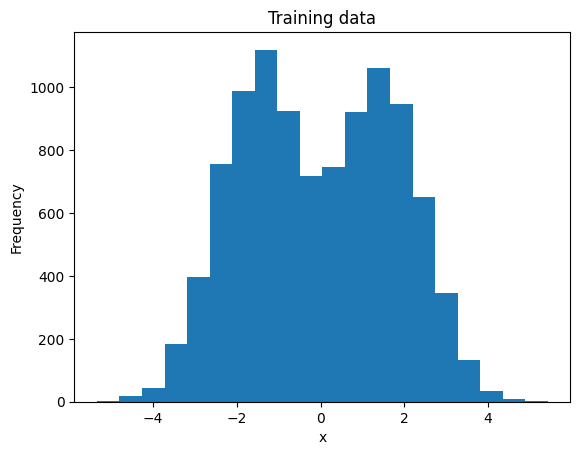

In [5]:
# true pdf and score
_x = sympy.symbols('x')
_p = 0.5*sympy.exp(-0.5*(_x - 1.5)**2)/sympy.sqrt(2*sympy.pi) + 0.5*sympy.exp(-0.5*(_x + 1.5)**2)/sympy.sqrt(2*sympy.pi)
_u = -sympy.log(_p)
_du = sympy.diff(_u, _x)
_s = - _du

true_pdf = sympy.lambdify(_x, _p, 'numpy')
true_score = sympy.lambdify(_x, _s, 'numpy')

# Generate training data
X1 = np.random.randn(Ntr) + 3 * (np.random.rand(Ntr) < 0.5) -1.5
plt.hist(X1, bins=20)
plt.title('Training data')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.show()

In [6]:
## create a model instance and fit it
model1 = ScoreBasedGenerator(estimator=LGBMRegressor(random_state=42), verbose=True)
model1.fit(X1, noise_strengths=np.sqrt(np.linspace(0, X1.var()*2, 100)[1:]))
# NOTE: you can specify the noise_strengths manually

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 990000, number of used features: 2
[LightGBM] [Info] Start training from score -0.000642


ScoreBasedGenerator(estimator=LGBMRegressor(random_state=42), verbose=True)

In [7]:
# predict statistics
print('mean and std of traing data', X1.mean(), X1.std())
print('mean and std of sampled data', model1.predict(aggregate='mean', return_std=True, sigma=[1e-3, 1e-2, 1e-1], alpha=1e-1))
# NOTE: In this case, model1.predict does not require features because y is not given, that is, no target variables.

mean and std of traing data -0.03933598336842621 1.8028987209509288


100%|██████████| 999/999 [00:02<00:00, 434.55it/s]

mean and std of sampled data (array(0.24369215), array(1.85518005))


100%|██████████| 999/999 [00:01<00:00, 506.64it/s]


X1_gen_lms.shape (1000,)
X1_gen_euler.shape (1000,)
X1_gen_em.shape (1000,)


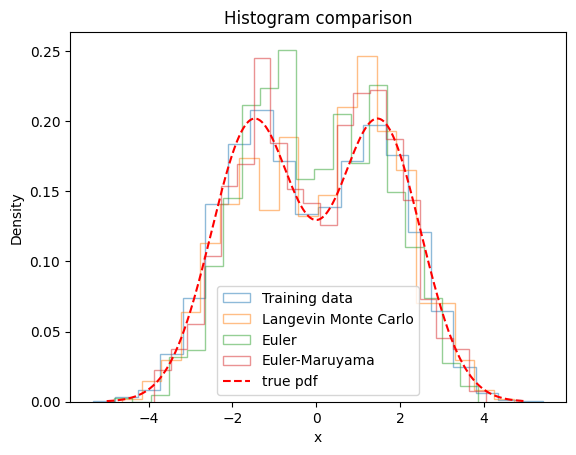

In [8]:
# generate samples
X1_gen_lmc = model1.sample(n_samples=1000, sampling_method=model1.SamplingMethod.LANGEVIN_MONTECARLO, init_sample=np.array([X1.mean()]), alpha=1e-2, sigma=[1e-3, 1e-2, 1e-1]).squeeze()
X1_gen_euler = model1.sample(n_samples=1000, sampling_method=model1.SamplingMethod.EULER).squeeze()
X1_gen_em = model1.sample(n_samples=1000, sampling_method=model1.SamplingMethod.EULER_MARUYAMA).squeeze()
print('X1_gen_lms.shape', X1_gen_lmc.shape)
print('X1_gen_euler.shape', X1_gen_euler.shape)
print('X1_gen_em.shape', X1_gen_em.shape)

# plot
plt.hist(X1, bins=20, alpha=0.5, label='Training data', histtype='step', density=True)
plt.hist(X1_gen_lmc, bins=20, alpha=0.5, label='Langevin Monte Carlo',  histtype='step', density=True)
plt.hist(X1_gen_euler, bins=20, alpha=0.5, label='Euler', histtype='step', density=True)
plt.hist(X1_gen_em, bins=20, alpha=0.5, label='Euler-Maruyama', histtype='step', density=True)
plt.plot(np.linspace(-5, 5, 1000), true_pdf(np.linspace(-5, 5, 1000)), 'r--', label='true pdf')
plt.title('Histogram comparison')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

100%|██████████| 999/999 [00:00<00:00, 1228.60it/s]


path_X1_gen_lmc.shape (1000, 100, 1, 1)
path_X1_gen_euler.shape (1000, 100, 1, 1)
path_X1_gen_em.shape (1000, 100, 1, 1)


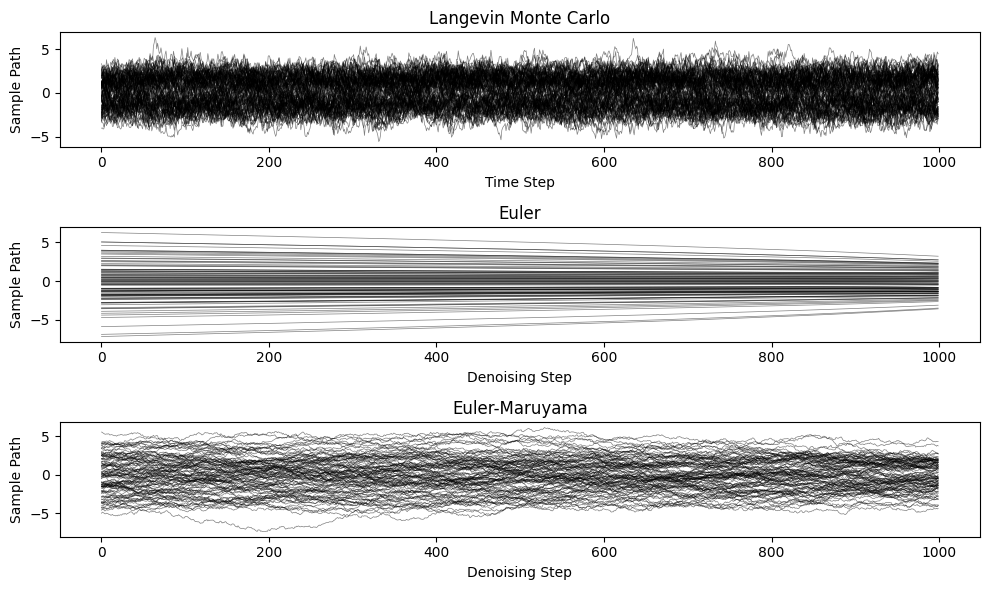

In [9]:
# look at sample paths
# NOTE: you can get sample paths with return_paths=True
path_X1_gen_lmc = model1.sample(n_samples=100, sampling_method=model1.SamplingMethod.LANGEVIN_MONTECARLO, init_sample=np.array([X1.mean()]), alpha=1e-1, sigma=[1e-3, 1e-2, 1e-1], return_paths=True)
path_X1_gen_euler = model1.sample(n_samples=100, sampling_method=model1.SamplingMethod.EULER, return_paths=True)
path_X1_gen_em = model1.sample(n_samples=100, sampling_method=model1.SamplingMethod.EULER_MARUYAMA, return_paths=True)
print('path_X1_gen_lmc.shape', path_X1_gen_lmc.shape)
print('path_X1_gen_euler.shape', path_X1_gen_euler.shape)
print('path_X1_gen_em.shape', path_X1_gen_em.shape)

fig, axs = plt.subplots(3, 1, figsize=(10, 6))
axs[0].plot(path_X1_gen_lmc[:, :100, 0, 0], 'k-', lw=0.5, alpha=0.5)
axs[0].set_title('Langevin Monte Carlo')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Sample Path')
axs[1].plot(path_X1_gen_euler[:, :100, 0, 0], 'k-', lw=0.5, alpha=0.5)
axs[1].set_title('Euler')
axs[1].set_xlabel('Denoising Step')
axs[1].set_ylabel('Sample Path')
axs[2].plot(path_X1_gen_em[:, :100, 0, 0], 'k-', lw=0.5, alpha=0.5)
axs[2].set_title('Euler-Maruyama')
axs[2].set_xlabel('Denoising Step')
axs[2].set_ylabel('Sample Path')
plt.tight_layout()
plt.show()

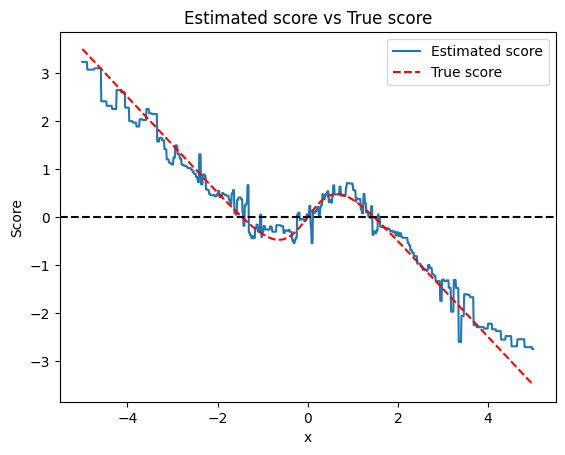

In [10]:
# estimeated score
plt.plot(np.linspace(-5, 5, 1000), model1.predict_score(np.linspace(-5, 5, 1000)[:, np.newaxis]), label='Estimated score')
plt.plot(np.linspace(-5, 5, 1000), true_score(np.linspace(-5, 5, 1000)), 'r--', label='True score')
plt.axhline(0, color='k', linestyle='--')
plt.title('Estimated score vs True score')
plt.xlabel('x')
plt.ylabel('Score')
plt.legend()
plt.show()

### 2D mixed Gaussian distribution

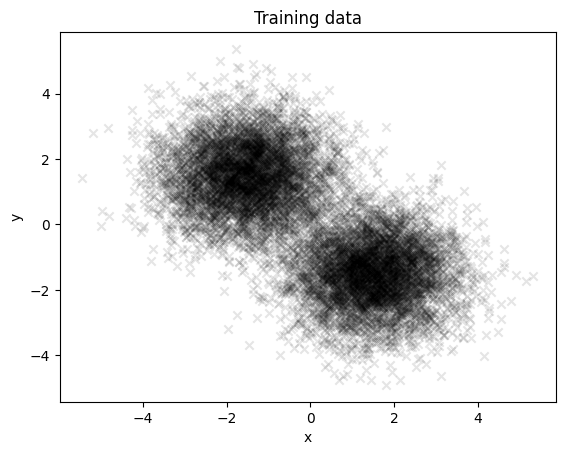

In [11]:
# true pdf and score
_x, _y = sympy.symbols('x y')
_p = 0.5*sympy.exp(-0.5*((_x - 1.5)**2+(_y + 1.5)**2))/sympy.pi + 0.5*sympy.exp(-0.5*((_x + 1.5)**2+(_y - 1.5)**2))/sympy.pi
_u = -sympy.log(_p)
_dudx = sympy.diff(_u, _x)
_dudy = sympy.diff(_u, _y)
_sx = - _dudx
_sy = - _dudy

true_pdf = sympy.lambdify((_x, _y), _p, 'numpy')
true_score = sympy.lambdify((_x, _y), (_sx, _sy), 'numpy')

# Generate training data
X2 = np.random.randn(Ntr, 2)
label = 2 * (np.random.rand(Ntr) < 0.5) - 1
X2[:, 0] += label * 1.5
X2[:, 1] -= label * 1.5
plt.scatter(X2[:, 0], X2[:, 1], color='k', alpha=0.1, marker='x')
plt.title('Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [12]:
## create a model instance and fit it
# NOTE: In multi-dimensional case, estimator must be able to handle multi-dimensional target variables like CatBoostRegressor.
model2 = ScoreBasedGenerator(estimator=CatBoostRegressor(random_state=42, loss_function='MultiRMSE', verbose=False), verbose=True)
model2.fit(X2, noise_strengths=np.sqrt(np.logspace(-3, np.log10(X2.var(axis=0).max()), 50)))

ScoreBasedGenerator(estimator=<catboost.core.CatBoostRegressor object at 0x000001BA25325ED0>,
                    verbose=True)

In [13]:
# predict statistics
print('mean and std of traing data', X2.mean(axis=0), X2.std(axis=0))
print('mean and std of sampled data', model2.predict(aggregate='mean', return_std=True, sigma=[1e-3, 1e-2, 1e-1], alpha=1e-2))

mean and std of traing data [-0.00944717 -0.00941656] [1.81040399 1.80864448]


100%|██████████| 999/999 [00:03<00:00, 320.77it/s]

mean and std of sampled data (array([ 0.7709831 , -0.59222326]), array([1.7121298 , 1.73481287]))


100%|██████████| 999/999 [00:03<00:00, 318.57it/s]


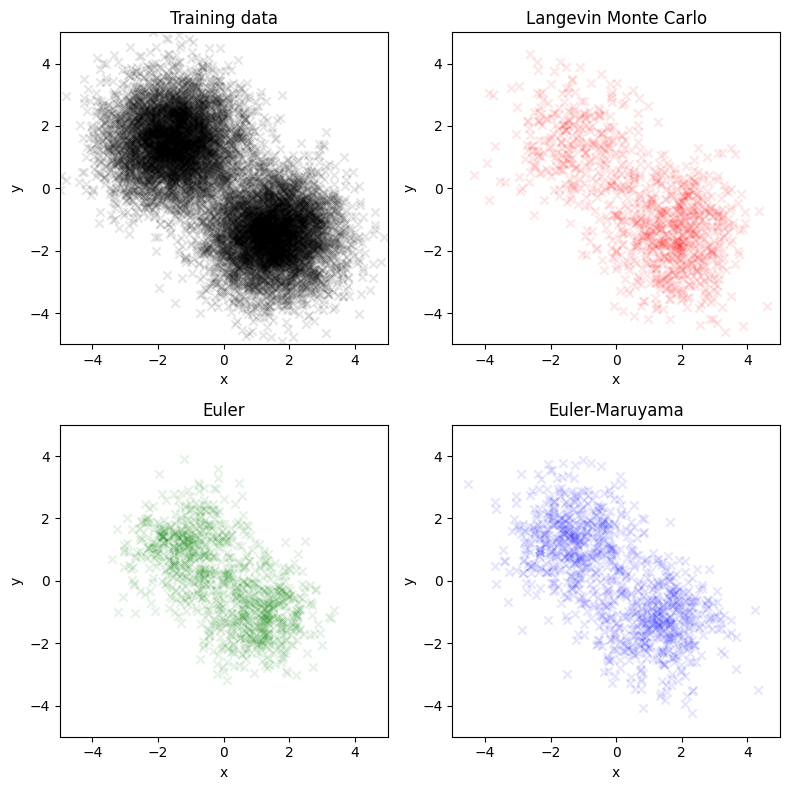

In [14]:
# generate samples
X2_gen_lmc = model2.sample(n_samples=1000, sampling_method=model2.SamplingMethod.LANGEVIN_MONTECARLO, alpha=1e-1, sigma=[1e-3, 1e-2, 1e-1]).squeeze()
X2_gen_euler = model2.sample(n_samples=1000, sampling_method=model2.SamplingMethod.EULER).squeeze()
X2_gen_em = model2.sample(n_samples=1000, sampling_method=model2.SamplingMethod.EULER_MARUYAMA).squeeze()

# plot
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].scatter(X2[:, 0], X2[:, 1], color='k', marker='x', alpha=0.1)
axs[0, 0].set_title('Training data')
axs[0, 1].scatter(X2_gen_lmc[:, 0], X2_gen_lmc[:, 1], color='r', marker='x', alpha=0.1, label='Langevin Monte Carlo')
axs[0, 1].set_title('Langevin Monte Carlo')
axs[1, 0].scatter(X2_gen_euler[:, 0], X2_gen_euler[:, 1], color='g', marker='x', alpha=0.1, label='Euler')
axs[1, 0].set_title('Euler')
axs[1, 1].scatter(X2_gen_em[:, 0], X2_gen_em[:, 1], color='b', marker='x', alpha=0.1, label='Euler-Maruyama')
axs[1, 1].set_title('Euler-Maruyama')
for ax in axs.flatten():
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
plt.tight_layout()
plt.show()

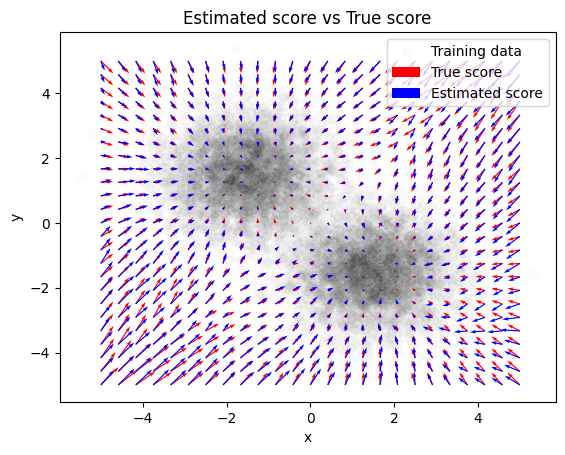

In [15]:
XX, YY = np.meshgrid(np.linspace(-5, 5, 25), np.linspace(-5, 5, 25))
S1, S2 = true_score(XX.flatten(), YY.flatten())
S12hat = model2.predict_score(np.c_[XX.flatten(), YY.flatten()])

plt.scatter(X2[:, 0], X2[:, 1], color='k', alpha=0.01, label='Training data')
plt.quiver(XX, YY, S1, S2, color='r', label='True score')
plt.quiver(XX, YY, S12hat[:, 0], S12hat[:, 1], color='b', label='Estimated score')
plt.title('Estimated score vs True score')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Generate samples of $y$ conditioned by $x$ with observed $\{(x_n, y_n)\}_{n=1}^N$

<span id="generate_samples_with_x_and_y"></span>

In this section, we will generate samples of $y$ conditioned by $x$ with observed $\{(x_n, y_n)\}_{n=1}^N$.

We will consider a case of supervised learning.
Specifically, we will consider a problem of predicting $y$ given $x$.



#### 1D example

For 1D case, we will use the following density function to generate samples of $y$ given $x$:
$$
p(y|x) = \mathcal{N}(y; \sin(3x), 0.05^2).
$$

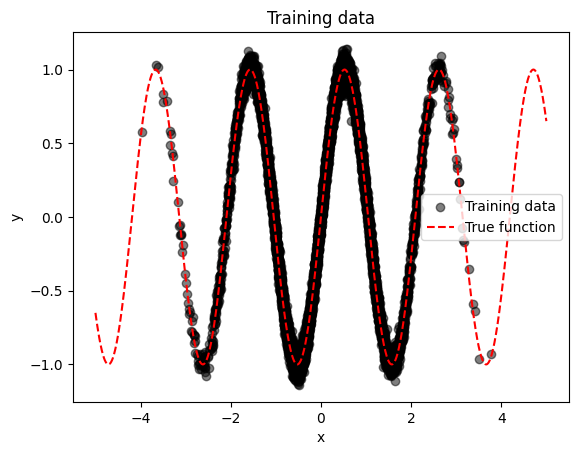

In [16]:
# true function
def true_f(x):
    return np.sin(3*x)

# Generate training data
X3 = np.random.randn(Ntr)
Y3 = true_f(X3) + np.random.randn(Ntr) * 0.05

plt.scatter(X3, Y3, color='k', alpha=0.5, label='Training data')
plt.plot(np.linspace(-5, 5, 1000), true_f(np.linspace(-5, 5, 1000)), 'r--', label='True function')
plt.title('Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [17]:
## create a model instance and fit it
# NOTE: In multi-dimensional case, estimator must be able to handle multi-dimensional target variables like CatBoostRegressor.
model3 = ScoreBasedGenerator(estimator=LGBMRegressor(random_state=42), verbose=True)
model3.fit(X3[:, np.newaxis], Y3, noise_strengths=np.sqrt(np.logspace(-4, np.log10(Y3.var()), 100)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 3
[LightGBM] [Info] Start training from score -0.000256


ScoreBasedGenerator(estimator=LGBMRegressor(random_state=42), verbose=True)

100%|██████████| 999/999 [00:19<00:00, 51.46it/s]


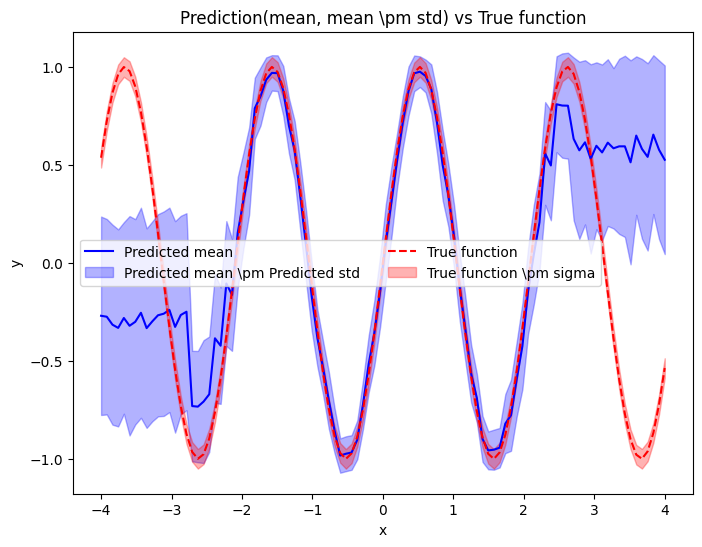

In [18]:
# predict statistics
X3new = np.linspace(-4, 4, 100)
Y3pred, Y3std = model3.predict(X3new[:, np.newaxis], return_std=True, n_samples=256, n_steps=1000, alpha=1e-3, sigma=[1e-3, 1e-2, 1e-1], init_sample=np.array([0]))
plt.figure(figsize=(8, 6))
plt.plot(X3new, Y3pred, 'b-', label='Predicted mean')
plt.fill_between(X3new, Y3pred - Y3std, Y3pred + Y3std, color='b', alpha=0.3, label='Predicted mean \pm Predicted std')
plt.plot(X3new, true_f(X3new), 'r--', label='True function')
plt.fill_between(X3new, true_f(X3new) - 0.05, true_f(X3new) + 0.05, color='r', alpha=0.3, label='True function \pm sigma')
plt.title('Prediction(mean, mean \pm std) vs True function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(ncol=2)
plt.show()

100%|██████████| 999/999 [00:19<00:00, 50.26it/s]


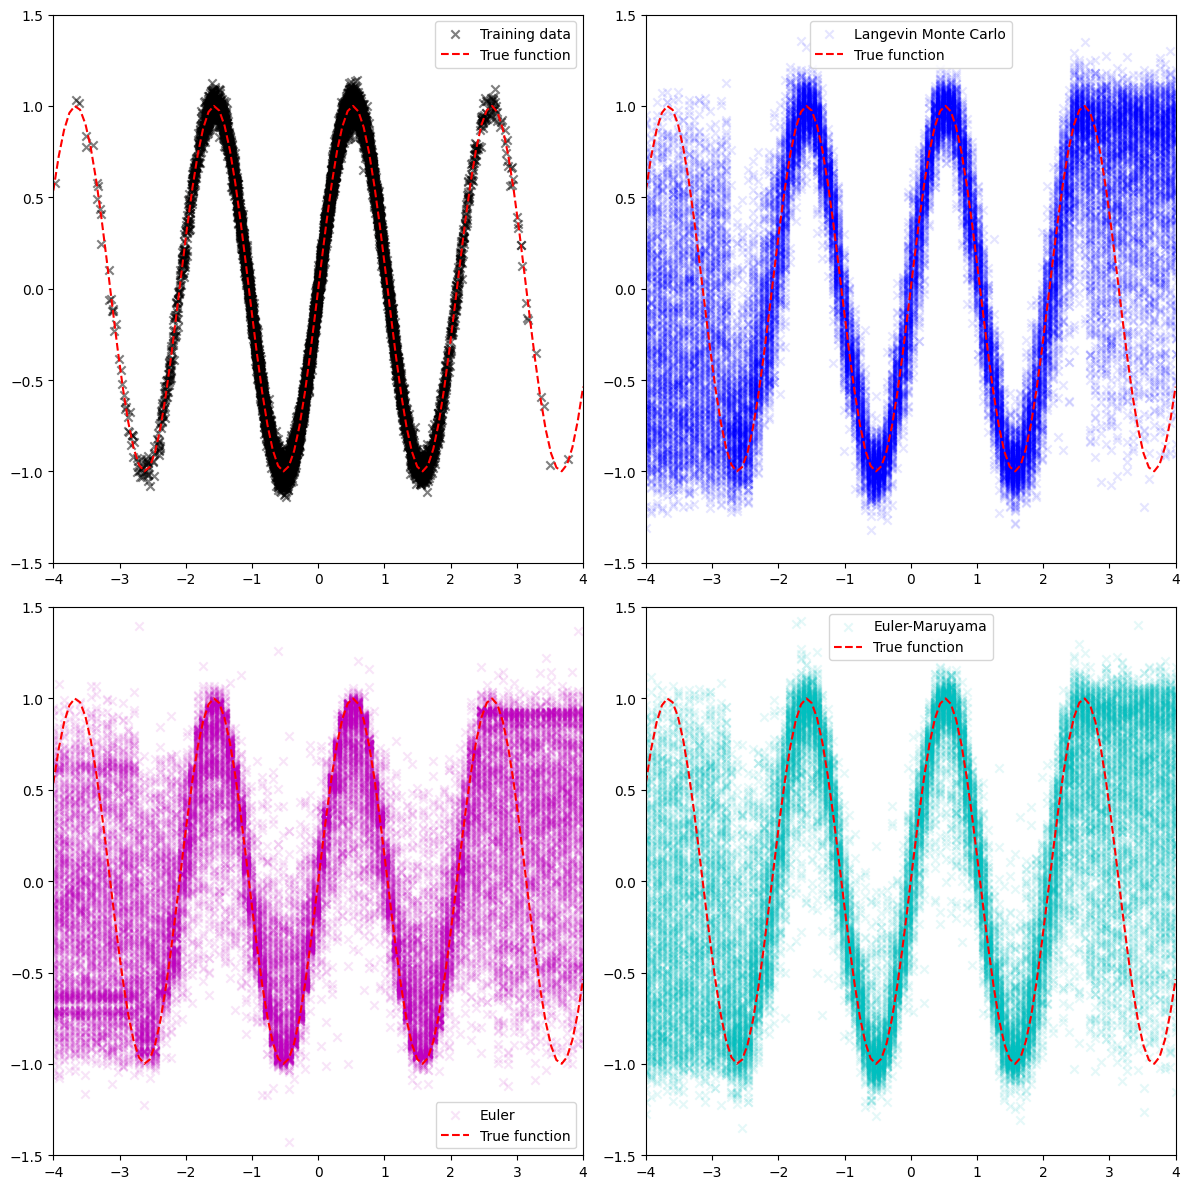

In [20]:
# generate samples
n_samples = 256
Y3_gen_lmc = model3.sample(X3new[:, np.newaxis], n_samples=n_samples, sampling_method=model3.SamplingMethod.LANGEVIN_MONTECARLO, sigma=[1e-3, 1e-2, 1e-1], alpha=1e-3).squeeze()
Y3_gen_euler = model3.sample(X3new[:, np.newaxis], n_samples=n_samples, sampling_method=model3.SamplingMethod.EULER).squeeze()
Y3_gen_em = model3.sample(X3new[:, np.newaxis], n_samples=n_samples, sampling_method=model3.SamplingMethod.EULER_MARUYAMA).squeeze()

# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].scatter(X3, Y3, color='k', marker='x', alpha=0.5, label='Training data')
for i in range(n_samples):
    axs[0, 1].scatter(X3new, Y3_gen_lmc[i], color='b', alpha=0.1, label='Langevin Monte Carlo' if i==0 else None, marker='x')
    axs[1, 0].scatter(X3new, Y3_gen_euler[i], color='m', alpha=0.1, label='Euler' if i==0 else None, marker='x')
    axs[1, 1].scatter(X3new, Y3_gen_em[i], color='c', alpha=0.1, label='Euler-Maruyama' if i==0 else None, marker='x')
for ax in axs.flatten():
    ax.plot(X3new, true_f(X3new), 'r--', label='True function')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-1.5, 1.5)
    ax.legend()
plt.tight_layout()
plt.show()

100%|██████████| 999/999 [00:00<00:00, 1154.08it/s]


path_Y3_gen_lmc.shape (1000, 100, 3, 1)
path_Y3_gen_euler.shape (1000, 100, 3, 1)
path_Y3_gen_em.shape (1000, 100, 3, 1)


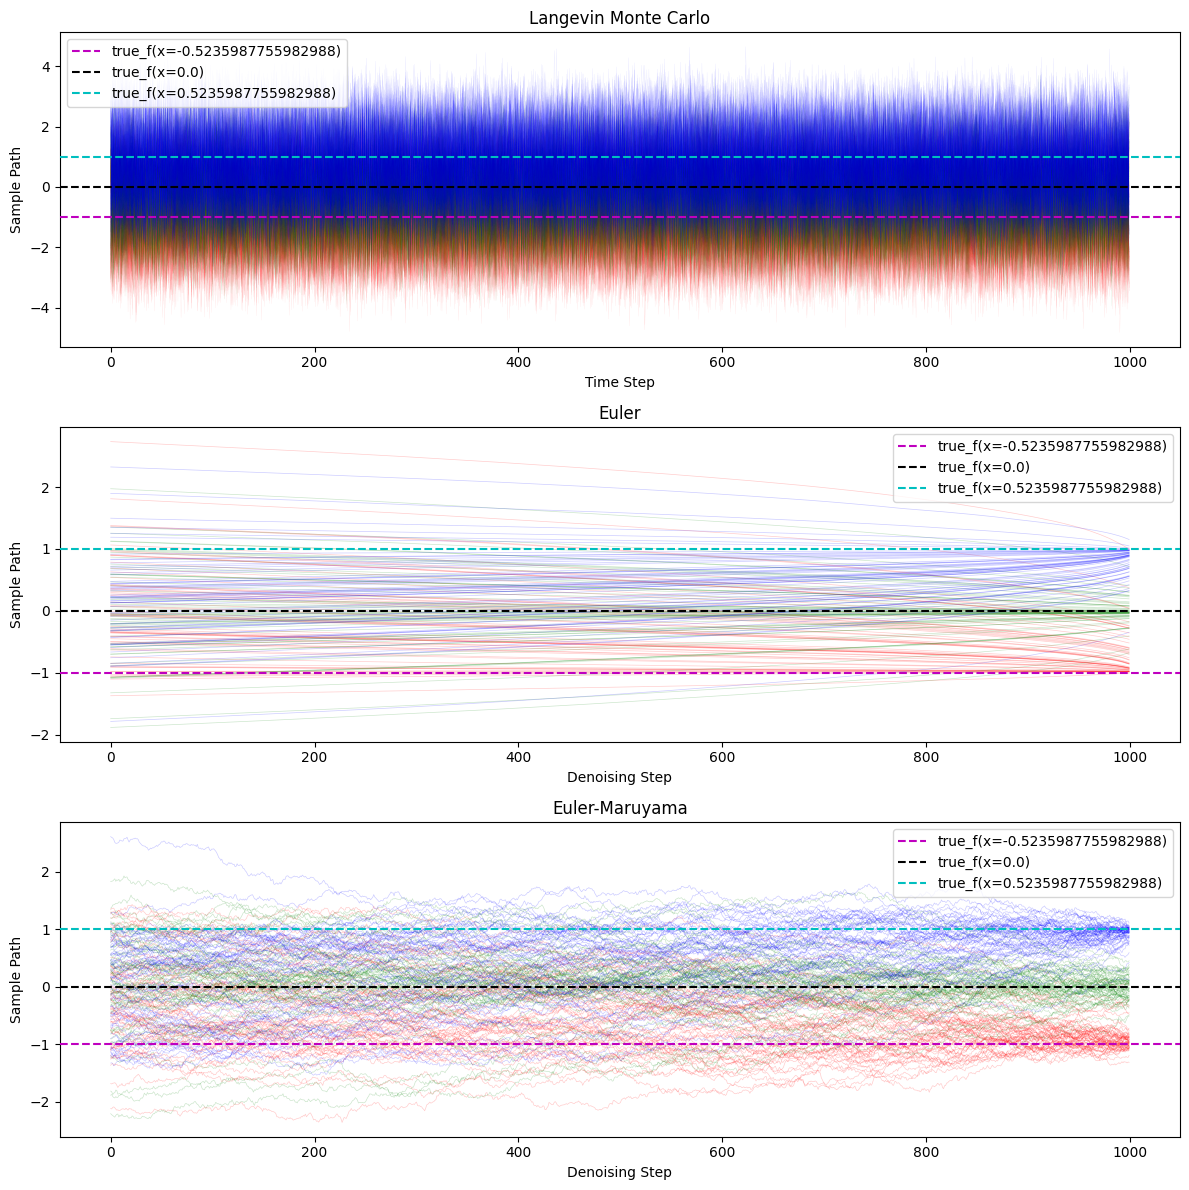

In [21]:
# look at sample paths
X3new2 = np.array([-np.pi/6, 0, np.pi/6])[:, np.newaxis]
path_Y3_gen_lmc = model3.sample(X3new2, n_samples=100, sampling_method=model1.SamplingMethod.LANGEVIN_MONTECARLO, init_sample=np.array([Y3.mean()]), alpha=1e-1, sigma=[1e-3, 1e-2, 1e-1], return_paths=True)
path_Y3_gen_euler = model3.sample(X3new2, n_samples=100, sampling_method=model1.SamplingMethod.EULER, return_paths=True)
path_Y3_gen_em = model3.sample(X3new2, n_samples=100, sampling_method=model1.SamplingMethod.EULER_MARUYAMA, return_paths=True)
print('path_Y3_gen_lmc.shape', path_Y3_gen_lmc.shape)
print('path_Y3_gen_euler.shape', path_Y3_gen_euler.shape)
print('path_Y3_gen_em.shape', path_Y3_gen_em.shape)

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
for i,(x,c, c2) in enumerate(zip(X3new2.flatten(), 'rgb', 'mkc')):
    axs[0].set_title('Langevin Monte Carlo')
    axs[0].set_xlabel('Time Step')
    axs[0].plot(path_Y3_gen_lmc[:, :60, i, 0], f'{c}-', lw=0.1, alpha=0.2)
    axs[0].axhline(true_f(x), color=c2, linestyle='--', label=f'true_f(x={x})', zorder=100)
    axs[1].set_title('Euler')
    axs[1].set_xlabel('Denoising Step')
    axs[1].plot(path_Y3_gen_euler[:, :60, i, 0], f'{c}-', lw=0.5, alpha=0.2)
    axs[1].axhline(true_f(x), color=c2, linestyle='--', label=f'true_f(x={x})', zorder=100)
    axs[2].axhline(true_f(x), color=c2, linestyle='--', label=f'true_f(x={x})', zorder=100)
    axs[2].set_title('Euler-Maruyama')
    axs[2].set_xlabel('Denoising Step')
    axs[2].plot(path_Y3_gen_em[:, :60, i, 0], f'{c}-', lw=0.5, alpha=0.2)
for ax in axs:
    ax.set_ylabel('Sample Path')
    ax.legend()
plt.tight_layout()
plt.show()

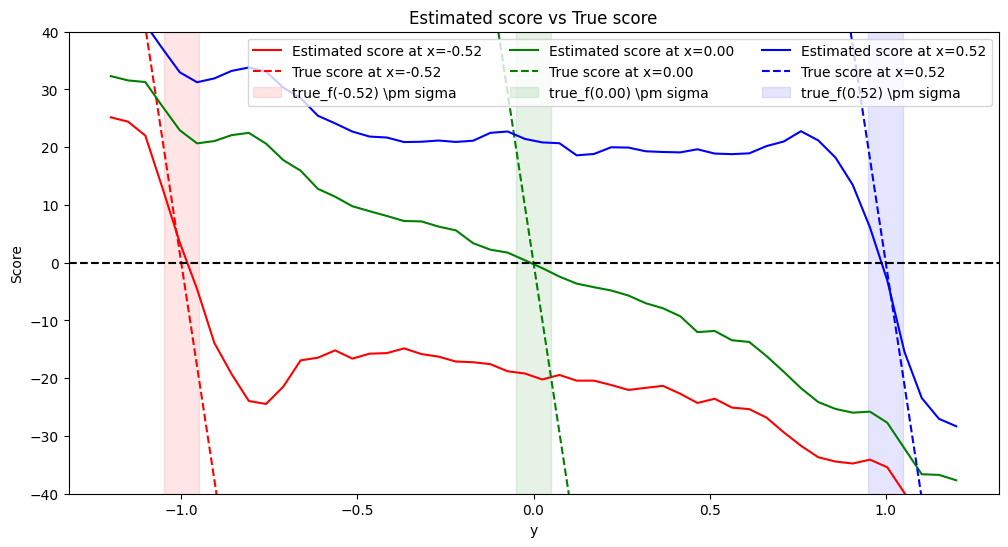

In [22]:
# estimeated score
ynew = np.linspace(-1.2, 1.2)
plt.figure(figsize=(12, 6))
for x,c in zip(X3new2.flatten(), 'rgb'):
    plt.plot(ynew, model3.predict_score(np.hstack([np.array([[x]*len(ynew)]).T, ynew[:, np.newaxis]])), label=f'Estimated score at x={x:.2f}', color=c)
    plt.plot(ynew, -(ynew-true_f(x))/0.05**2, f'{c}--', label=f'True score at x={x:.2f}')
    plt.fill_betweenx(y=[-100, 100], x1=true_f(x)-0.05, x2=true_f(x)+0.05, color=c, alpha=0.1, label=f'true_f({x:.2f}) \pm sigma')
plt.axhline(0, color='k', linestyle='--')
plt.ylim(-40, 40)
plt.title('Estimated score vs True score')
plt.xlabel('y')
plt.ylabel('Score')
plt.legend(ncol=3, loc='upper right')
plt.show()


#### 2D example

On the other hand, for 2D case, we will use the following density function to generate samples of $y$ given $x$.

In this case, we will use the toy dataset of `sklearn.datasets.make_moons`.



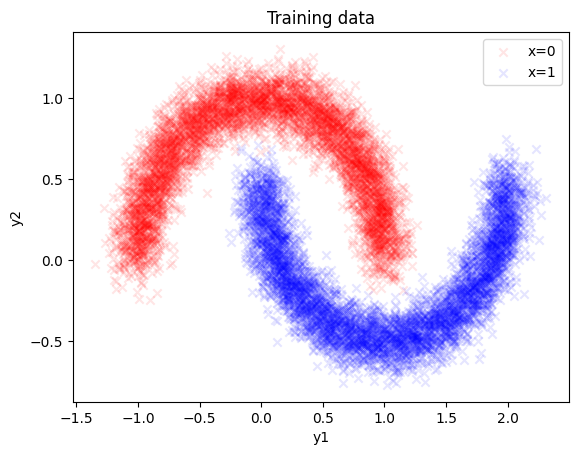

In [23]:
Y4, X4 = make_moons(n_samples=Ntr, noise=0.1, random_state=42)

plt.scatter(Y4[X4==0, 0], Y4[X4==0, 1], color='r', label='x=0', marker='x', alpha=0.1)
plt.scatter(Y4[X4==1, 0], Y4[X4==1, 1], color='b', label='x=1', marker='x', alpha=0.1)
plt.title('Training data')
plt.xlabel('y1')
plt.ylabel('y2')
plt.legend()
plt.show()

In [24]:
model4 = ScoreBasedGenerator(estimator=CatBoostRegressor(random_state=42, loss_function='MultiRMSE', verbose=False), verbose=True)
model4.fit(X4[:, np.newaxis], Y4, noise_strengths=np.sqrt(np.logspace(-3, np.log10(Y4.var(axis=0).max()), 50)))

ScoreBasedGenerator(estimator=<catboost.core.CatBoostRegressor object at 0x000001BA5673A4A0>,
                    verbose=True)

In [25]:
# generate samples
Xnew = np.arange(2)[:, np.newaxis]
Y4_gen_lmc = model4.sample(Xnew, n_samples=1000, sampling_method=model4.SamplingMethod.LANGEVIN_MONTECARLO, alpha=1e-2, sigma=[1e-3, 1e-2, 1e-1, 1], init_sample=np.array([0, 0])).squeeze()
Y4_gen_euler = model4.sample(Xnew, n_samples=1000, sampling_method=model4.SamplingMethod.EULER).squeeze()
Y4_gen_em = model4.sample(Xnew, n_samples=1000, sampling_method=model4.SamplingMethod.EULER_MARUYAMA).squeeze()



100%|██████████| 999/999 [00:05<00:00, 193.04it/s]


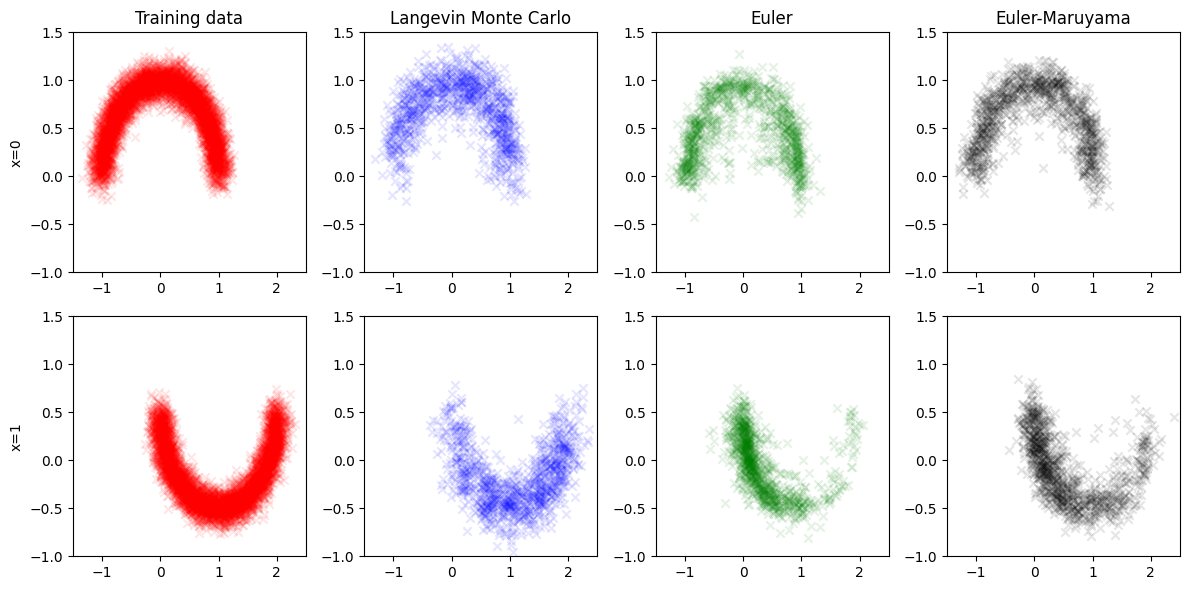

In [26]:
# plot samples
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, (axs_, x) in enumerate(zip(axs, Xnew.flatten())):
    axs_[0].scatter(Y4[X4==i, 0], Y4[X4==i, 1], color='r', alpha=0.1, label=f'x={x}', marker='x')
    axs_[1].scatter(Y4_gen_lmc[:, i, 0], Y4_gen_lmc[:, i, 1], color='b', alpha=0.1, label=f'x={x}', marker='x')
    axs_[2].scatter(Y4_gen_euler[:, i, 0], Y4_gen_euler[:, i, 1], color='g', alpha=0.1, label=f'x={x}', marker='x')
    axs_[3].scatter(Y4_gen_em[:, i, 0], Y4_gen_em[:, i, 1], color='k', alpha=0.1, label=f'x={x}', marker='x')
axs[0, 0].set_title('Training data')
axs[0, 1].set_title('Langevin Monte Carlo')
axs[0, 2].set_title('Euler')
axs[0, 3].set_title('Euler-Maruyama')
axs[0, 0].set_ylabel('x=0')
axs[1, 0].set_ylabel('x=1')
for ax in axs.flatten():
    ax.set_xlim(-1.5, 2.5)
    ax.set_ylim(-1, 1.5)
plt.tight_layout()
plt.show()

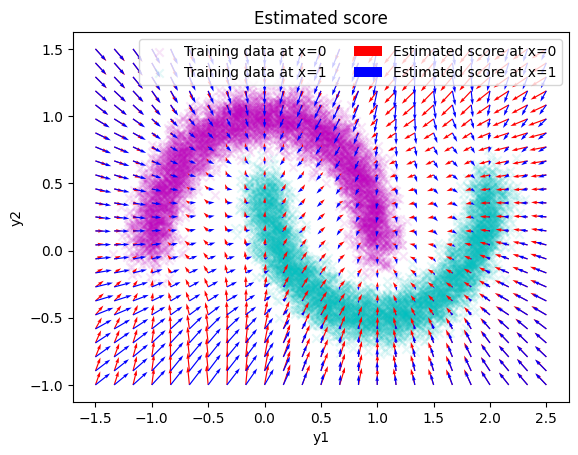

In [27]:
YY1, YY2 = np.meshgrid(np.linspace(-1.5, 2.5, 25), np.linspace(-1, 1.5, 25))
S_X0 = model4.predict_score(np.zeros((YY1.size, 1)), np.c_[YY1.flatten(), YY2.flatten()])
S_X1 = model4.predict_score(np.ones((YY1.size, 1)), np.c_[YY1.flatten(), YY2.flatten()])

plt.scatter(Y4[X4==0, 0], Y4[X4==0, 1], color='m', label='Training data at x=0', marker='x', alpha=0.1)
plt.scatter(Y4[X4==1, 0], Y4[X4==1, 1], color='c', label='Training data at x=1', marker='x', alpha=0.1)
plt.quiver(YY1, YY2, S_X0[:, 0].reshape(*YY1.shape), S_X0[:, 1].reshape(*YY1.shape), color='r', label='Estimated score at x=0')
plt.quiver(YY1, YY2, S_X1[:, 0].reshape(*YY1.shape), S_X1[:, 1].reshape(*YY1.shape), color='b', label='Estimated score at x=1')
plt.title('Estimated score')
plt.xlabel('y1')
plt.ylabel('y2')
plt.legend(ncol=2)
plt.show()

## Advanced Usage

### Generate samples of $x$ with observed $\{x_n\}_{n=1}^N$ with $x$ restricted

<span id="generate_samples_with_restricted_x"></span>

Here is an example of generating samples of $x$ with observed $\{x_n\}_{n=1}^N$ with $x$ restricted.

$$
p(x) = \beta(x;\alpha, \beta) := \frac{1}{B(\alpha, \beta)} x^{\alpha-1} (1-x)^{\beta-1},
$$

where $B(\alpha, \beta)$ is the beta function. Especially, we will consider the case of $\alpha = 2, \beta = 5$.

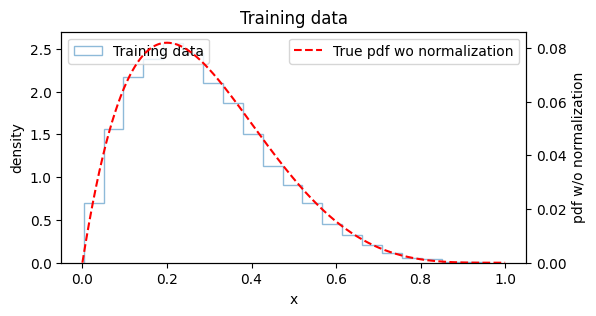

In [28]:
alpha, beta = 2, 5
_x = sympy.symbols('x')
_p_wo_normalize = _x**(alpha-1) * (1-_x)**(beta-1)
_u_wo_normalize = -sympy.log(_p_wo_normalize)
_du = sympy.diff(_u_wo_normalize, _x)
_s = - _du

true_pdf_wo_normalize = sympy.lambdify(_x, _p_wo_normalize, 'numpy')
true_score = sympy.lambdify(_x, _s, 'numpy')

# Generate training data
X5 = np.random.beta(alpha, beta, Ntr)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
axd = ax.twinx()
ax.hist(X5, bins=20, alpha=0.5, label='Training data', histtype='step', density=True)
axd.plot(np.linspace(0, 1, 1000), true_pdf_wo_normalize(np.linspace(0, 1, 1000)), 'r--', label='True pdf wo normalization')
ax.set_title('Training data')
ax.set_xlabel('x')
ax.set_ylabel('density')
axd.set_ylabel('pdf w/o normalization')
ax.legend(loc='upper left')
axd.legend(loc='upper right')
axd.set_ylim(0)
plt.show()

In [29]:
model5 = ScoreBasedGenerator(estimator=LGBMRegressor(random_state=42), verbose=True)
model5.fit(X5[:, np.newaxis], noise_strengths=np.sqrt(np.logspace(-3, np.log10(X5.var()), 100)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 2
[LightGBM] [Info] Start training from score -0.009728


ScoreBasedGenerator(estimator=LGBMRegressor(random_state=42), verbose=True)

In [30]:
X5.mean()

0.2839106208578662

In [31]:
# predict statistics
print('mean and std of traing data', X5.mean(), X5.std())
print('mean and std of sampled data without restrictions', model5.predict(aggregate='mean', return_std=True, sigma=1e-3, alpha=1e-2, init_sample=np.array([X5.mean()])))
print('mean and std of sampled data with restrictions', model5.predict(aggregate='mean', return_std=True, sigma=1e-3, alpha=1e-2, init_sample=np.array([X5.mean()]), is_in_valid_domain_func=lambda x: (x>0) * (x<1)))
# NOTE: In this case, model5.predict does not require features because y is not given, that is, no target variables.

mean and std of traing data 0.2839106208578662 0.15844639233096108


100%|██████████| 999/999 [00:01<00:00, 650.77it/s]


mean and std of sampled data without restrictions (array(0.34454118), array(0.19662314))


100%|██████████| 999/999 [00:10<00:00, 93.91it/s] 

mean and std of sampled data with restrictions (array(0.31954948), array(0.16646119))


In [32]:
# generate samples
X5_gen_lmc_wo_restrictions = model5.sample(n_samples=1000, sampling_method=model5.SamplingMethod.LANGEVIN_MONTECARLO, init_sample=np.array([X5.mean()]), alpha=1e-2, sigma=1e-3).squeeze()
X5_gen_lmc_w_restrictions = model5.sample(n_samples=1000, sampling_method=model5.SamplingMethod.LANGEVIN_MONTECARLO, init_sample=np.array([X5.mean()]), alpha=1e-2, sigma=1e-3, is_in_valid_domain_func=lambda x: (x>0) * (x<1)).squeeze()
print('X5_gen_lmc_wo_restrictions.shape', X5_gen_lmc_wo_restrictions.shape)
print('X5_gen_lmc_w_restrictions.shape', X5_gen_lmc_w_restrictions.shape)

100%|██████████| 999/999 [00:10<00:00, 96.84it/s]

X5_gen_lmc_wo_restrictions.shape (1000,)
X5_gen_lmc_w_restrictions.shape (1000,)


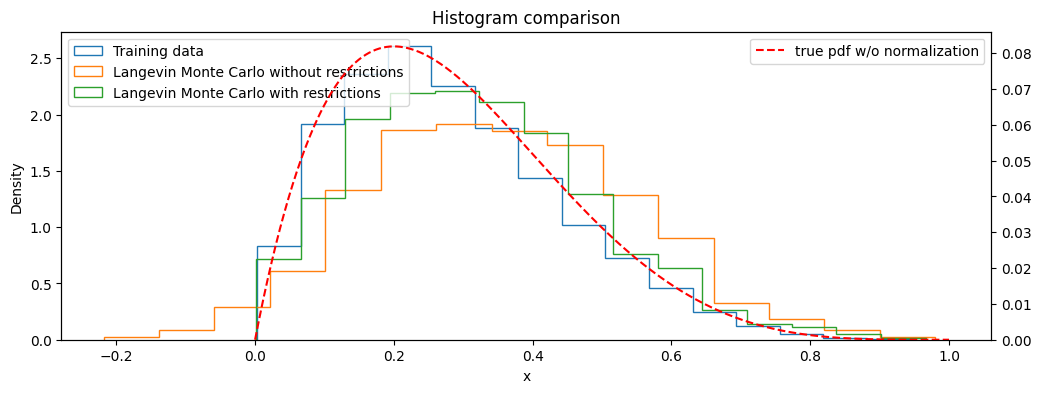

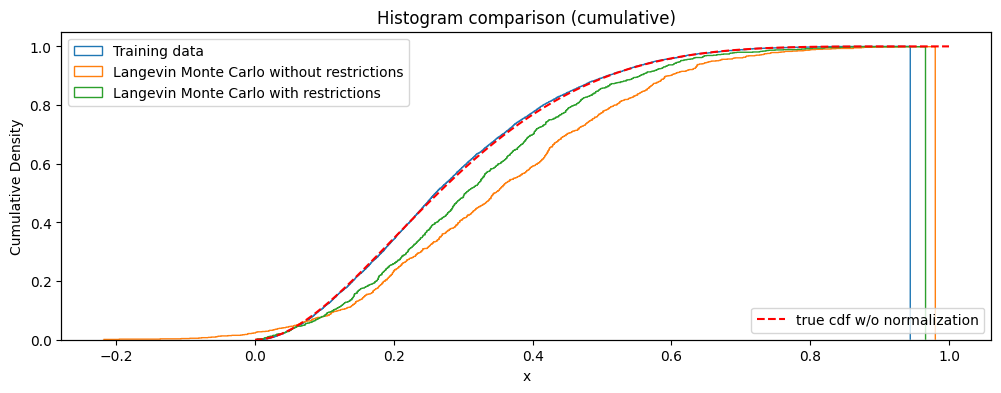

In [33]:
# plot
fig, ax = plt.subplots(figsize=(12, 4))
axd = ax.twinx()
ax.hist(X5, bins=15, label='Training data', histtype='step', density=True)
ax.hist(X5_gen_lmc_wo_restrictions, bins=15, label='Langevin Monte Carlo without restrictions',  histtype='step', density=True)
ax.hist(X5_gen_lmc_w_restrictions, bins=15, label='Langevin Monte Carlo with restrictions',  histtype='step', density=True)
axd.plot(np.linspace(0, 1, 1000), true_pdf_wo_normalize(np.linspace(0, 1, 1000)), 'r--', label='true pdf w/o normalization')
ax.set_title('Histogram comparison')
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend(loc='upper left')
axd.legend(loc='upper right')
axd.set_ylim(0)
plt.show()

# plot
fig, ax = plt.subplots(figsize=(12, 4))
axd = ax.twinx()
ax.hist(X5, bins=len(X5), label='Training data', histtype='step', density=True, cumulative=True)
ax.hist(X5_gen_lmc_wo_restrictions, bins=len(X5), label='Langevin Monte Carlo without restrictions',  histtype='step', density=True, cumulative=True)
ax.hist(X5_gen_lmc_w_restrictions, bins=len(X5), label='Langevin Monte Carlo with restrictions',  histtype='step', density=True, cumulative=True)
axd.plot(np.linspace(0, 1, 1000), np.cumsum(true_pdf_wo_normalize(np.linspace(0, 1, 1000))), 'r--', label='true cdf w/o normalization')
ax.set_title('Histogram comparison (cumulative)')
ax.set_xlabel('x')
ax.set_ylabel('Cumulative Density')
ax.legend(loc='upper left')
axd.legend(loc='lower right')
axd.set_ylim(0)
axd.set_yticks([])
plt.show()

### Generate samples of $y$ conditioned by $x$ with observed $\{(x_n, y_n)\}_{n=1}^N$ with $y$ restricted partially

<span id="generate_samples_with_partially_restricted"></span>

In this section, we will see an example of generating samples of $y$ conditioned by $x$ with observed $\{(x_n, y_n)\}_{n=1}^N$ with $y$ restricted partially.

This example shows you how to generate samples of $y_{0, 1, \cdots, i-1, i+1, \cdots, \cdots}$ conditioned by $x$ and $y_i$ after training a model for $p(y|x)$ with observed $\{(x_n, y_n)\}_{n=1}^N$ with $y$ restricted partially.

We will use `sklearn.datasets.make_moons`.

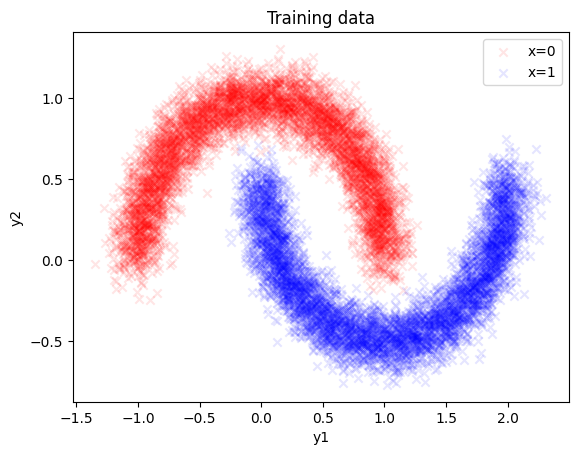

In [34]:
Y6, X6 = make_moons(n_samples=Ntr, noise=0.1, random_state=42)

plt.scatter(Y6[X6==0, 0], Y6[X6==0, 1], color='r', label='x=0', marker='x', alpha=0.1)
plt.scatter(Y6[X6==1, 0], Y6[X6==1, 1], color='b', label='x=1', marker='x', alpha=0.1)
plt.title('Training data')
plt.xlabel('y1')
plt.ylabel('y2')
plt.legend()
plt.show()

In [35]:
model6_1= ScoreBasedGenerator(estimator=CatBoostRegressor(random_state=42, loss_function='MultiRMSE', verbose=False), verbose=True)
model6_1.fit(Y6, noise_strengths=np.sqrt(np.logspace(-3, np.log10(Y6.var(axis=0).max()), 50)))



ScoreBasedGenerator(estimator=<catboost.core.CatBoostRegressor object at 0x000001BA56987970>,
                    verbose=True)

In [36]:
# generate samples
_init_sample = model6_1.predict(aggregate='median', return_std=False, alpha=1e-2, init_sample=Y6.mean(axis=0), conditioned_by={0: 0.5}, sigma=1e-4)
print(_init_sample)
Y6_gen_1_y1_eq_0p5 = model6_1.sample(conditioned_by={0: 0.5}, n_samples=256, alpha=1e-4, sigma=[1e-4, 1e-3, 1e-2, 1e-1], init_sample=_init_sample, sampling_method=model6_1.SamplingMethod.LANGEVIN_MONTECARLO).squeeze()
# Y6_gen_1_y1_eq_0p5 = model6_1.sample(conditioned_by={0: 0.5}, n_samples=256, sampling_method=model6_1.SamplingMethod.EULER).squeeze()
# Y6_gen_1_y1_eq_0p5 = model6_1.sample(conditioned_by={0: 0.5}, n_samples=256, sampling_method=model6_1.SamplingMethod.EULER_MARUYAMA, init_sample=_init_sample).squeeze()
_init_sample = model6_1.predict(aggregate='median', return_std=False, alpha=1e-2, init_sample=Y6.mean(axis=0), conditioned_by={1: 0.25}, sigma=1e-4)
print(_init_sample)
Y6_gen_1_y2_eq_0p25 = model6_1.sample(conditioned_by={1: 0.25}, n_samples=256, alpha=1e-4, sigma=[1e-4, 1e-3, 1e-2, 1e-1], sampling_method=model6_1.SamplingMethod.LANGEVIN_MONTECARLO).squeeze()
# Y6_gen_1_y2_eq_0p25 = model6_1.sample(conditioned_by={1: 0.25}, n_samples=256, sampling_method=model6_1.SamplingMethod.EULER).squeeze()
# Y6_gen_1_y2_eq_0p25 = model6_1.sample(conditioned_by={1: 0.25}, n_samples=256, sampling_method=model6_1.SamplingMethod.EULER_MARUYAMA, init_sample=_init_sample).squeeze()

100%|██████████| 999/999 [00:03<00:00, 317.80it/s]


[0.5        0.50397721]


100%|██████████| 999/999 [00:03<00:00, 317.60it/s]


[0.89141331 0.25      ]


100%|██████████| 999/999 [00:01<00:00, 632.75it/s]


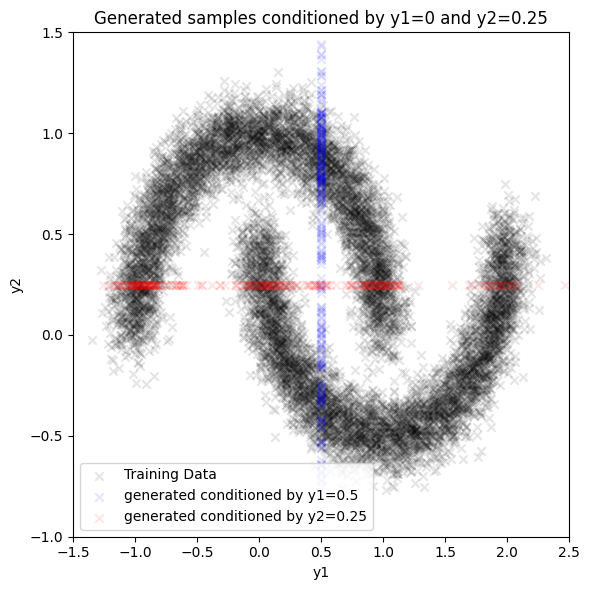

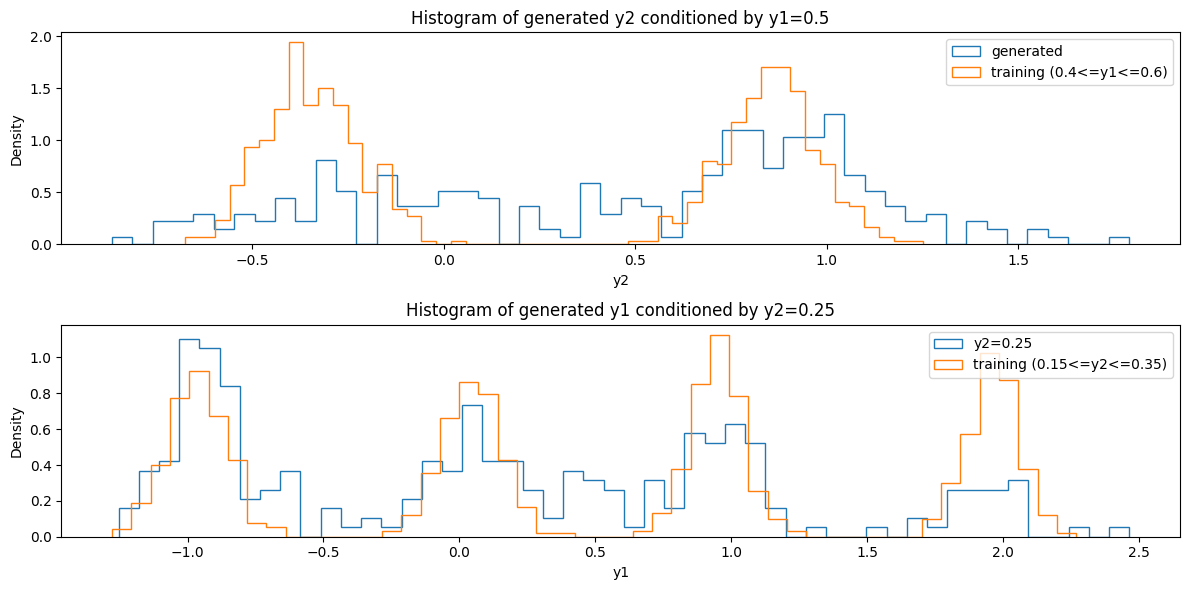

In [37]:
# plot samples

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(Y6[:, 0], Y6[:, 1], color='k', alpha=0.1, label=f'Training Data', marker='x')
ax.scatter(Y6_gen_1_y1_eq_0p5[:, 0], Y6_gen_1_y1_eq_0p5[:, 1], color='b', alpha=0.1, label=f'generated conditioned by y1=0.5', marker='x')
ax.scatter(Y6_gen_1_y2_eq_0p25[:, 0], Y6_gen_1_y2_eq_0p25[:, 1], color='r', alpha=0.1, label=f'generated conditioned by y2=0.25', marker='x')
ax.set_xlim(-1.5, 2.5)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_title('Generated samples conditioned by y1=0 and y2=0.25')
ax.legend()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].set_title('Histogram of generated y2 conditioned by y1=0.5')
axs[0].hist(Y6_gen_1_y1_eq_0p5[:, 1], density=True, bins=50, label='generated', histtype='step')
axs[0].hist(Y6[abs(Y6[:,0]-0.5)<0.1, 1], density=True, bins=50, label='training (0.4<=y1<=0.6)', histtype='step')
axs[0].set_xlabel('y2')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[1].set_title('Histogram of generated y1 conditioned by y2=0.25')
axs[1].hist(Y6_gen_1_y2_eq_0p25[:, 0], label='y2=0.25', density=True, bins=50, histtype='step')
axs[1].hist(Y6[abs(Y6[:,1]-0.25)<0.1, 0], label='training (0.15<=y2<=0.35)', density=True, bins=50, histtype='step')
axs[1].set_xlabel('y1')
axs[1].set_ylabel('Density')
axs[1].legend()
plt.tight_layout()
plt.show()

In [38]:
model6_2= ScoreBasedGenerator(estimator=CatBoostRegressor(random_state=42, loss_function='MultiRMSE', verbose=False), verbose=True)
model6_2.fit(X6[:, np.newaxis], Y6, noise_strengths=np.sqrt(np.logspace(-3, 0, 50)))

ScoreBasedGenerator(estimator=<catboost.core.CatBoostRegressor object at 0x000001BA56739000>,
                    verbose=True)

In [39]:
Xnew = np.arange(2)[:, np.newaxis]
Y6_gen_2_y1_eq_0p5 = model6_2.sample(Xnew, n_steps=1000, conditioned_by={0: 0.5}, n_samples=512, alpha=1e-4, sigma=[1e-4, 1e-3, 1e-2, 1e-1], sampling_method=model6_2.SamplingMethod.LANGEVIN_MONTECARLO).squeeze()
# Y6_gen_2_y1_eq_0p5 = model6_2.sample(Xnew, n_steps=1000, conditioned_by={0: 0.5}, n_samples=512, sampling_method=model6_2.SamplingMethod.EULER).squeeze()
# Y6_gen_2_y1_eq_0p5 = model6_2.sample(Xnew, n_steps=1000, conditioned_by={0: 0.5}, n_samples=512, sampling_method=model6_2.SamplingMethod.EULER_MARUYAMA).squeeze()
Y6_gen_2_y2_eq_0p25 = model6_2.sample(Xnew, n_steps=1000, conditioned_by={1: 0.25}, n_samples=512, alpha=1e-4, sigma=[1e-4, 1e-3, 1e-2, 1e-1], sampling_method=model6_2.SamplingMethod.LANGEVIN_MONTECARLO).squeeze()
# Y6_gen_2_y2_eq_0p25 = model6_2.sample(Xnew, n_steps=1000, conditioned_by={1: 0.25}, n_samples=512, sampling_method=model6_2.SamplingMethod.EULER).squeeze()
# Y6_gen_2_y2_eq_0p25 = model6_2.sample(Xnew, n_steps=1000, conditioned_by={1: 0.25}, n_samples=512, sampling_method=model6_2.SamplingMethod.EULER_MARUYAMA).squeeze()

100%|██████████| 999/999 [00:03<00:00, 303.50it/s]


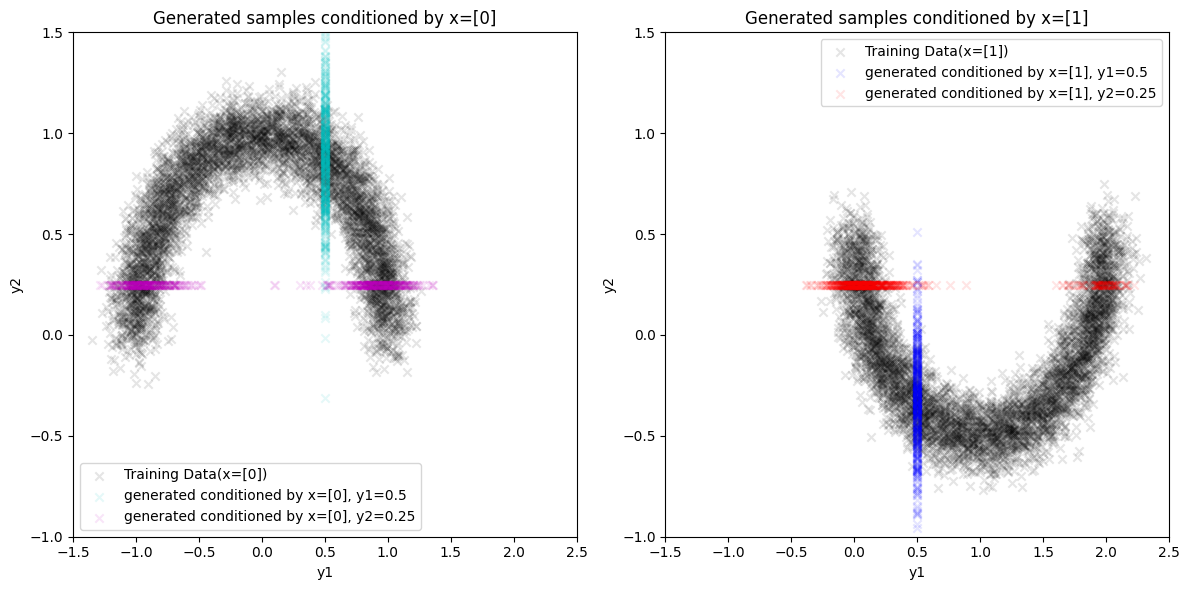

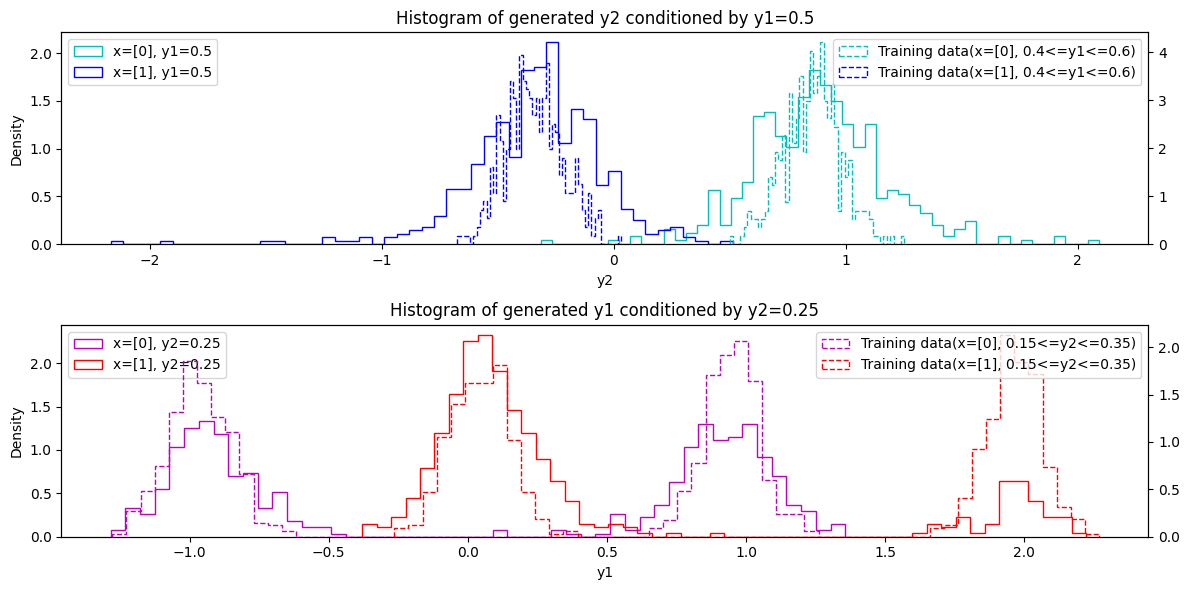

In [40]:
# plot samples

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, (x, ax,c1,c2) in enumerate(zip(Xnew, axs, 'cb', 'mr')):
    ax.scatter(Y6[X6==x, 0], Y6[X6==x, 1], color='k', alpha=0.1, label=f'Training Data(x={x})', marker='x')
    ax.scatter(Y6_gen_2_y1_eq_0p5[:, i, 0], Y6_gen_2_y1_eq_0p5[:, i, 1], color=c1, alpha=0.1, label=f'generated conditioned by x={x}, y1=0.5', marker='x')
    ax.scatter(Y6_gen_2_y2_eq_0p25[:, i, 0], Y6_gen_2_y2_eq_0p25[:, i, 1], color=c2, alpha=0.1, label=f'generated conditioned by x={x}, y2=0.25', marker='x')
    ax.set_xlim(-1.5, 2.5)
    ax.set_ylim(-1, 1.5)
    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_title(f'Generated samples conditioned by x={x}')
    ax.legend()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axds = [ax.twinx() for ax in axs]
axs[0].set_title('Histogram of generated y2 conditioned by y1=0.5')
for x,c in zip(Xnew, 'cb'):
    axds[0].hist(Y6[(X6==x)&(abs(Y6[:,0]-0.5)<1e-1),1], color=c, linestyle='--', label=f'Training data(x={x}, 0.4<=y1<=0.6)', density=True, bins=50, histtype='step')
axs[0].hist(Y6_gen_2_y1_eq_0p5[:, 0, 1], color='c', label=f'x={Xnew[0]}, y1=0.5', density=True, bins=50, histtype='step')
axs[0].hist(Y6_gen_2_y1_eq_0p5[:, 1, 1], color='b', label=f'x={Xnew[1]}, y1=0.5', density=True, bins=50, histtype='step')
axs[0].set_xlabel('y2')
axs[0].set_ylabel('Density')
axs[0].legend(loc='upper left')
axds[0].set_ylim(0)
axds[0].legend(loc='upper right')
axs[1].set_title('Histogram of generated y1 conditioned by y2=0.25')
for x,c in zip(Xnew, 'mr'):
    axds[1].hist(Y6[(X6==x)&(abs(Y6[:,1]-0.25)<1e-1),0], color=c, linestyle='--', label=f'Training data(x={x}, 0.15<=y2<=0.35)', density=True, bins=50, histtype='step')
axs[1].hist(Y6_gen_2_y2_eq_0p25[:, 0, 0], color='m', label=f'x={Xnew[0]}, y2=0.25', density=True, bins=50, histtype='step')
axs[1].hist(Y6_gen_2_y2_eq_0p25[:, 1, 0], color='r', label=f'x={Xnew[1]}, y2=0.25', density=True, bins=50, histtype='step')
axs[1].set_xlabel('y1')
axs[1].set_ylabel('Density')
axs[1].legend(loc='upper left')
axds[1].set_ylim(0)
axds[1].legend(loc='upper right')
plt.tight_layout()
plt.show()